In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D

from keras.applications.densenet import DenseNet121
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/h5file-86/frist68epoch.h5
/kaggle/input/augmented-xray-dataset/metadata.csv
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/00025583_005.png
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person1230_virus_2081.jpeg
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person124_virus_238.jpeg
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person1590_bacteria_4175.jpeg
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person57_bacteria_270.jpeg
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person1527_virus_2661.jpeg
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person622_bacteria_2494.jpeg
/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xr

In [11]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [12]:
directory = '/kaggle/input/augmented-xray-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
data_df = pd.DataFrame(columns=['directory', 'class'])
count = 0
for filename in os.listdir(directory):
    if not filename == 'metadata.csv':
        for img in os.listdir(directory+"/"+filename):
            data_df = data_df.append({'directory':directory+"/"+filename+"/"+img, 'class':filename}, ignore_index = True)

In [13]:
data_df = data_df.sample(frac = 1, random_state=7)
data_df.head(5)

,directory,class
1599,/kaggle/input/augmented-xray-dataset/COVID19_P...,normal
662,/kaggle/input/augmented-xray-dataset/COVID19_P...,pneumonia
3086,/kaggle/input/augmented-xray-dataset/COVID19_P...,covid
3001,/kaggle/input/augmented-xray-dataset/COVID19_P...,normal
433,/kaggle/input/augmented-xray-dataset/COVID19_P...,pneumonia


In [14]:
data_df

,directory,class
1599,/kaggle/input/augmented-xray-dataset/COVID19_P...,normal
662,/kaggle/input/augmented-xray-dataset/COVID19_P...,pneumonia
3086,/kaggle/input/augmented-xray-dataset/COVID19_P...,covid
3001,/kaggle/input/augmented-xray-dataset/COVID19_P...,normal
433,/kaggle/input/augmented-xray-dataset/COVID19_P...,pneumonia
...,...,...
4307,/kaggle/input/augmented-xray-dataset/COVID19_P...,covid
2550,/kaggle/input/augmented-xray-dataset/COVID19_P...,normal
537,/kaggle/input/augmented-xray-dataset/COVID19_P...,pneumonia
1220,/kaggle/input/augmented-xray-dataset/COVID19_P...,pneumonia


normal 00000373_000.png
(1024, 1024, 3)


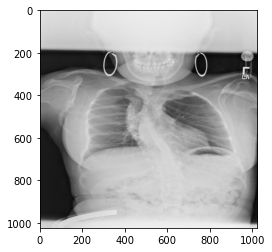

In [15]:
#Simple check by reading an image
import cv2
import matplotlib.pyplot as plt
test_img_path = data_df.iloc[0][0]
test_img = cv2.imread(test_img_path)
print(test_img_path.split("/")[-2], test_img_path.split("/")[-1])
print(test_img.shape)
plt.imshow(test_img)

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

#* Defining parameters
batch_size = 24
size = (224,224,3)
img_width = img_hight = size[0]
random_state = 7
#Class_mapping = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}
#classes = list(Class_mapping.values())
classes = list(data_df['class'].unique())

#* Creating data generators
data_gen = ImageDataGenerator(rescale=1./255)

In [17]:
from sklearn.model_selection import train_test_split
# Paper_train_split , Paper_test_split , _ , _ = train_test_split(data_df, data_df['class'], train_size=0.85, random_state=7, stratify=data_df['class'])
train_data , val_test_data , train_class , val_test_class = train_test_split(data_df, data_df['class'], train_size=0.8, random_state=7, stratify=data_df['class'])
# val_data , test_data , val_class , test_class = train_test_split(val_test_data, val_test_class, train_size=0.5, random_state=7, stratify=val_test_class)

paper_train_data = data_gen.flow_from_dataframe(train_data, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False,seed=42,shuffle=True)

paper_validation_data = data_gen.flow_from_dataframe(val_test_data, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False,seed=42,shuffle=True)

#Validation Data Generator
paper_test_data = data_gen.flow_from_dataframe(val_test_data, x_col='directory', y_col='class',
                                          image_size=(img_hight, img_width), target_size=(
                                              img_hight, img_hight), color_mode='rgb',
                                          batch_size=batch_size, class_mode='categorical',
                                          classes=classes, subset=None, validate_filenames= False,seed=42,shuffle=False)




Found 3660 non-validated image filenames belonging to 3 classes.
Found 915 non-validated image filenames belonging to 3 classes.
Found 915 non-validated image filenames belonging to 3 classes.


In [18]:
# pd.DataFrame.to_csv(test_data, 'test_data.csv', index=False)

In [19]:
from keras.models import Sequential, Model
model = Sequential()

model.add(Conv2D(input_shape=(224, 224,3),filters=64, kernel_size=(5, 5),  padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(Conv2D(filters=64, kernel_size=(5, 5),  padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(Conv2D(filters=64, kernel_size=(5, 5),  padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(Conv2D(filters=64, kernel_size=(5, 5),  padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(MaxPool2D(pool_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same",kernel_regularizer=keras.regularizers.l2(0.0001), activation='LeakyReLU'))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding="same",kernel_regularizer=keras.regularizers.l2(0.0001),activation='LeakyReLU'))
model.add(MaxPool2D(pool_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512,activation = "LeakyReLU"))
model.add(Dropout(0.3))

model.add(Dense(512,activation = "LeakyReLU"))
model.add(Dropout(0.3))

model.add(Dense(512,activation = "LeakyReLU"))
model.add(Dropout(0.3))

model.add(Dense(3,activation = "softmax"))

model.summary()

2023-02-22 17:54:36.356852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 17:54:36.357859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 17:54:36.514005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 17:54:36.514928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 17:54:36.515704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      102464    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      102464    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 45, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 64)        0

In [20]:
checkpoint =tf.keras.callbacks.ModelCheckpoint(filepath='paper_model_adam_80_20.h5', 
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=False)

earlystop= tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 30,
                          verbose = 1,
                          restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [21]:
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6),metrics = ["accuracy"])

history= model.fit(
     paper_train_data, 
     validation_data= paper_validation_data, 
     epochs=125, 
     callbacks=[earlystop,checkpoint, reduce_lr])



2023-02-22 17:54:40.866475: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/125


2023-02-22 17:54:44.146922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


153/153 [==============================] - 147s 879ms/step - loss: 0.7745 - accuracy: 0.7527 - val_loss: 1.3276 - val_accuracy: 0.3519

Epoch 00001: val_accuracy improved from -inf to 0.35191, saving model to paper_model_adam_80_20.h5
Epoch 2/125
153/153 [==============================] - 81s 532ms/step - loss: 0.5619 - accuracy: 0.8284 - val_loss: 1.0300 - val_accuracy: 0.4689

Epoch 00002: val_accuracy improved from 0.35191 to 0.46885, saving model to paper_model_adam_80_20.h5
Epoch 3/125
153/153 [==============================] - 82s 534ms/step - loss: 0.4295 - accuracy: 0.8730 - val_loss: 0.6747 - val_accuracy: 0.7093

Epoch 00003: val_accuracy improved from 0.46885 to 0.70929, saving model to paper_model_adam_80_20.h5
Epoch 4/125
153/153 [==============================] - 82s 534ms/step - loss: 0.3849 - accuracy: 0.8943 - val_loss: 0.3925 - val_accuracy: 0.8798

Epoch 00004: val_accuracy improved from 0.70929 to 0.87978, saving model to paper_model_adam_80_20.h5
Epoch 5/125
153/15

In [22]:
#  model.save("model2_adam.h5")

In [73]:
# pd.DataFrame(history.history)
# pd.DataFrame.to_csv(pd.DataFrame(history),'history_model2_adam_80_20.csv', index=False)

In [77]:
 model = keras.models.load_model('/kaggle/working/paper_model_adam_80_20.h5')

In [95]:
history = pd.read_csv('/kaggle/working/history_model2_adam.csv')


In [78]:
model.evaluate(paper_validation_data)

39/39 [==============================] - 14s 336ms/step - loss: 0.2697 - accuracy: 0.9541


[0.2696877717971802, 0.9540983438491821]

In [80]:
predict=model.predict(paper_test_data, verbose=1 )

39/39 [==============================] - 12s 311ms/step


In [82]:
predict

array([[3.0440989e-07, 9.6908510e-01, 3.0914605e-02],
       [1.0677401e-06, 3.7548645e-05, 9.9996138e-01],
       [3.3897377e-05, 9.6864128e-01, 3.1324696e-02],
       ...,
       [2.2328776e-07, 1.4730522e-07, 9.9999964e-01],
       [8.7098760e-04, 9.8955256e-01, 9.5764212e-03],
       [9.9999785e-01, 2.1051549e-06, 2.4399389e-08]], dtype=float32)

In [84]:
predictions = np.array(list(map(lambda x: np.argmax(x),predict )))


In [85]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(paper_test_data.labels,predictions)
accuracy_score

0.9540983606557377

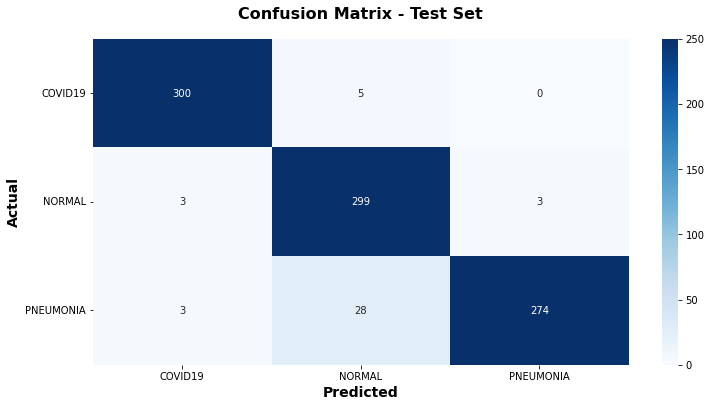

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL", "PNEUMONIA"]

# y_pred = model.predict(test_set)
y_true=paper_test_data.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [88]:
from sklearn.metrics import classification_report
target_names = ['COVID19','NORMAL','PNEUMONIA']
report=classification_report(paper_test_data.labels,predictions, target_names=target_names)
print(report)

              precision    recall  f1-score   support

     COVID19       0.98      0.98      0.98       305
      NORMAL       0.90      0.98      0.94       305
   PNEUMONIA       0.99      0.90      0.94       305

    accuracy                           0.95       915
   macro avg       0.96      0.95      0.95       915
weighted avg       0.96      0.95      0.95       915



In [89]:
reportdic=classification_report(paper_test_data.labels,predictions, target_names=target_names, output_dict=True)
print(reportdic)

reportdic_df = pd.DataFrame(reportdic)
reportdic_df.head()

{'COVID19': {'precision': 0.9803921568627451, 'recall': 0.9836065573770492, 'f1-score': 0.9819967266775778, 'support': 305}, 'NORMAL': {'precision': 0.9006024096385542, 'recall': 0.980327868852459, 'f1-score': 0.9387755102040817, 'support': 305}, 'PNEUMONIA': {'precision': 0.9891696750902527, 'recall': 0.898360655737705, 'f1-score': 0.9415807560137458, 'support': 305}, 'accuracy': 0.9540983606557377, 'macro avg': {'precision': 0.9567214138638507, 'recall': 0.9540983606557377, 'f1-score': 0.9541176642984684, 'support': 915}, 'weighted avg': {'precision': 0.9567214138638507, 'recall': 0.9540983606557377, 'f1-score': 0.9541176642984684, 'support': 915}}


,COVID19,NORMAL,PNEUMONIA,accuracy,macro avg,weighted avg
precision,0.980392,0.900602,0.989170,0.954098,0.956721,0.956721
recall,0.983607,0.980328,0.898361,0.954098,0.954098,0.954098
f1-score,0.981997,0.938776,0.941581,0.954098,0.954118,0.954118
support,305.000000,305.000000,305.000000,0.954098,915.000000,915.000000


In [90]:
reportdic_df = reportdic_df.drop(columns=['macro avg', 	'weighted avg','accuracy'])

reportdic_df = reportdic_df.drop(labels='support', axis=0)
reportdic_df= reportdic_df.mul(100)
reportdic_df.head()

,COVID19,NORMAL,PNEUMONIA
precision,98.039216,90.060241,98.916968
recall,98.360656,98.032787,89.836066
f1-score,98.199673,93.877551,94.158076


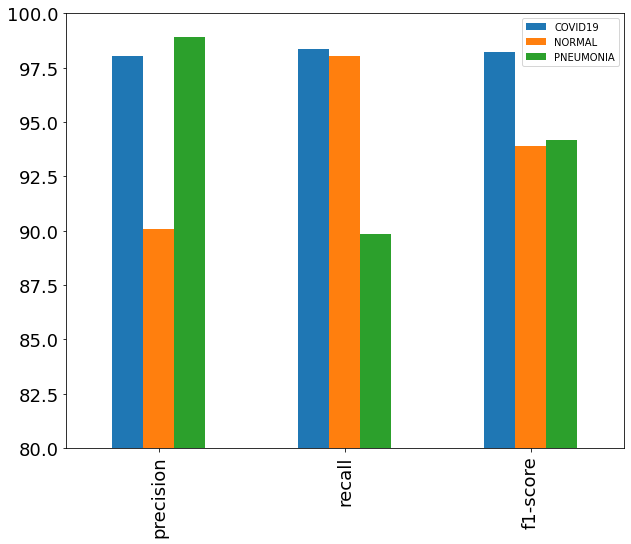

In [91]:
pd.DataFrame.to_csv(reportdic_df, 'reportresults.csv', index=False)
reportdic_df.plot(kind = 'bar',figsize=(10,8),fontsize=18,ylim=(80,100))
plt.show()

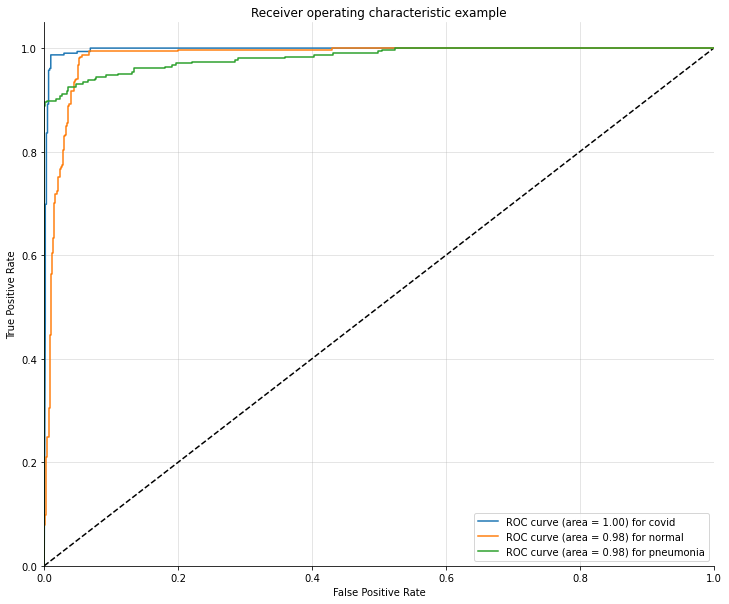

In [97]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

class_to_label_map = {2 : 'pneumonia', 0 : 'covid', 1 : 'normal'}
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(paper_test_data.labels,predict, n_classes=3, figsize=(12, 10))

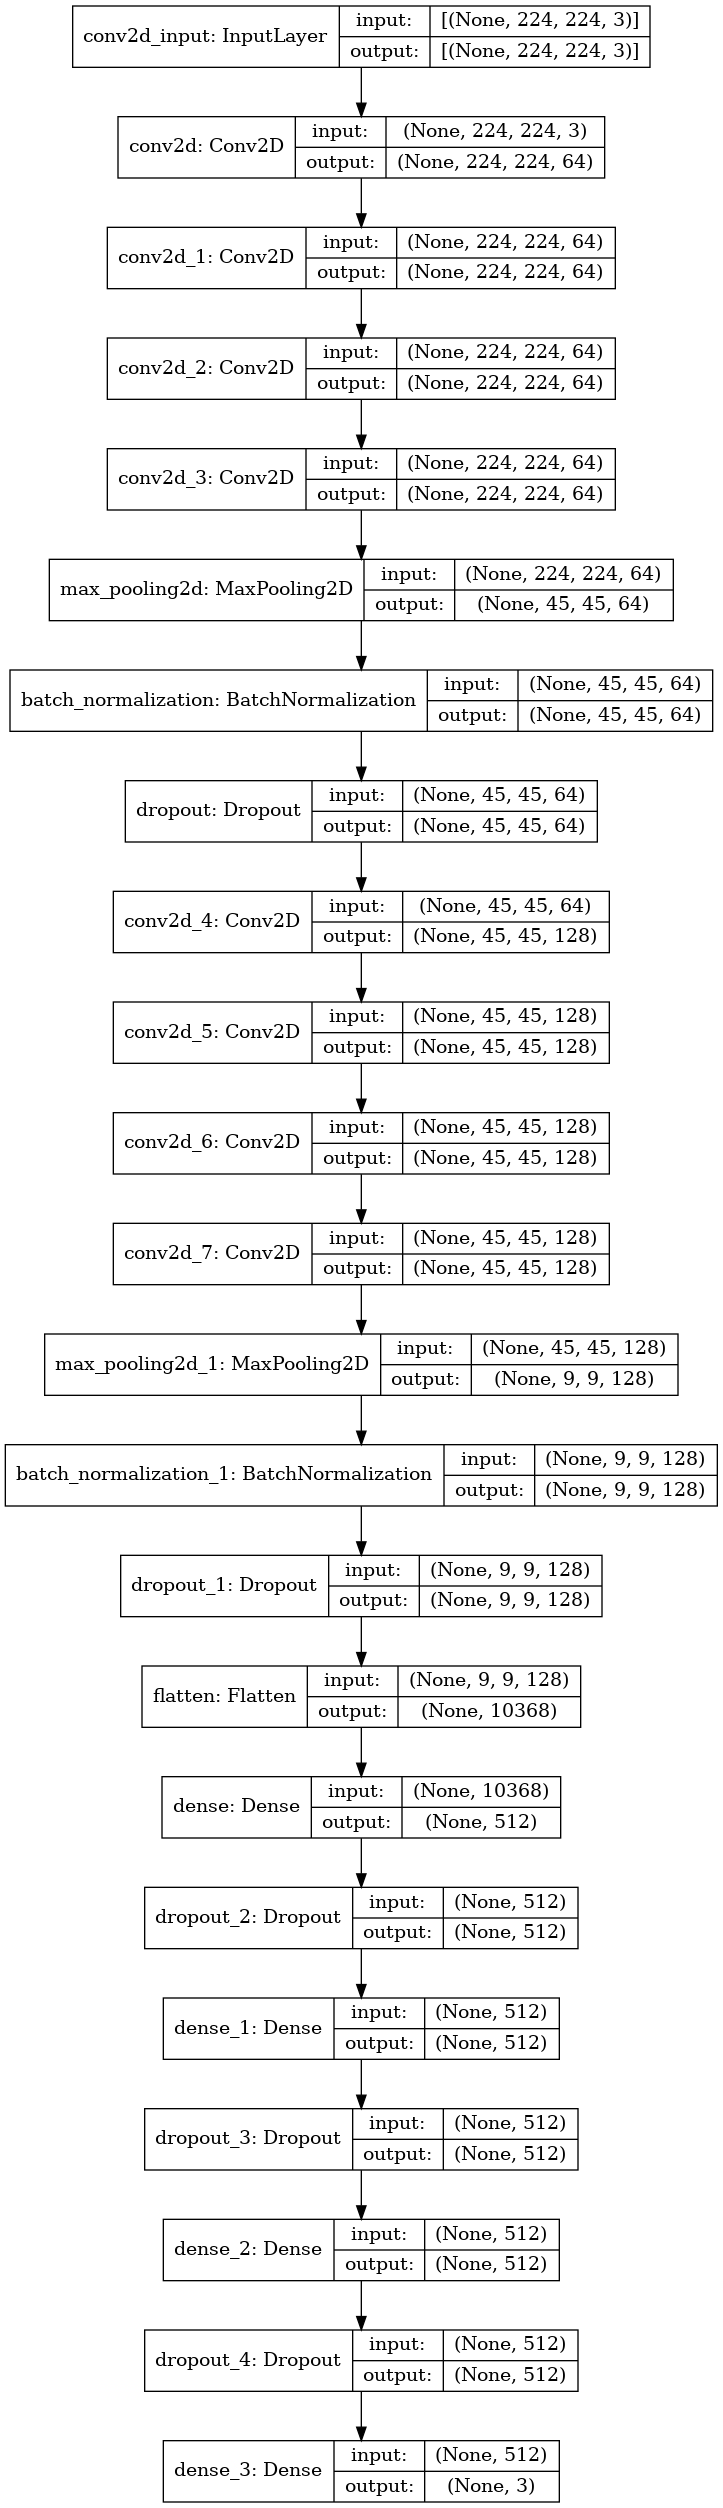

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

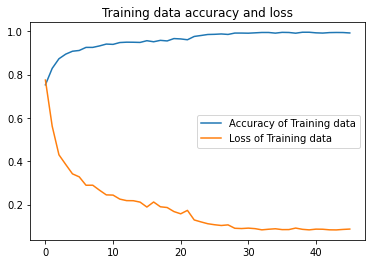

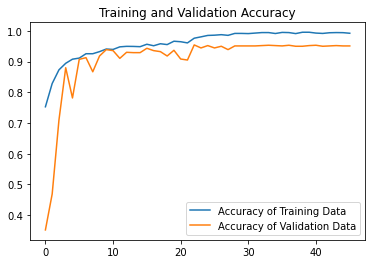

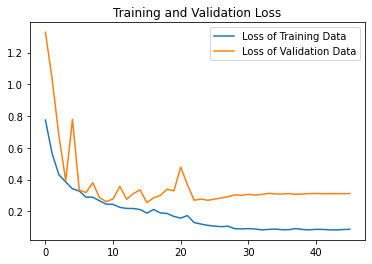

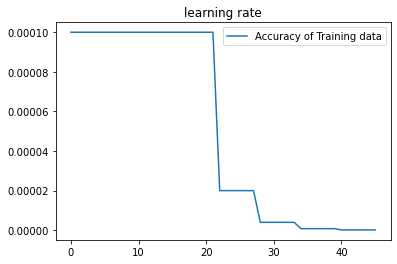

<Figure size 432x288 with 0 Axes>

In [96]:

# Plotting
acc = history['accuracy']
loss =history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
lr= history['lr']

epochs = range(len(acc))
plt.plot(epochs, acc, label='Accuracy of Training data')
plt.plot(epochs, loss, label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, acc, label='Accuracy of Training Data')
plt.plot(epochs, val_acc, label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, label='Loss of Training Data')
plt.plot(epochs, val_loss, label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, lr, label='Accuracy of Training data')
plt.title('learning rate')
plt.legend(loc=0)
plt.figure()

plt.show()

In [46]:
# print(classification_report(y_true, predictions))
# pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))